In [ ]:
### TO DO
# test pyfftw against numpy fft?
# remove shotnoise in P22 directly from 22-matrices?
#

In [452]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.special import gamma
from numpy.fft import rfft
#import pyfftw
import matplotlib.pyplot as plt
import time
import os

In [453]:
NFFT = 256
kminFFT = 1.5e-5
kmaxFFT = 100.

# Test FFTLog

In [454]:
def CoefPow(ki, Pi, bias = -1.6, Nmax = NFFT, kmin = kminFFT, kmax = kmaxFFT):
    
    dk = np.log(kmax/kmin) / (Nmax-1.)
    
    Pinterp = interp1d(ki, Pi)
    
    k = np.empty(Nmax)
    Pk = np.empty(Nmax)
    
    for i in range(Nmax): 
        k[i] = kmin * np.exp(i*dk)
        Pk[i] = Pinterp(k[i]) * np.exp(-bias*i*dk)
    
    Pow = np.empty(Nmax+1, dtype = complex)
    Coef = np.empty(Nmax+1, dtype = complex)
    
    for i in range(Nmax+1): 
        Pow[i] = bias + 1j * 2.*np.pi / (Nmax*dk) * (i - Nmax/2.)
    
    tmp = rfft(Pk)
    
    print (Pk.shape, tmp.shape)
    
    for i in range(Nmax+1):
        if (i < Nmax/2): Coef[i] = np.conj(tmp[int(Nmax/2-i)]) * kmin**(-Pow[i]) / float(Nmax)
        else: Coef[i] = tmp[int(i-Nmax/2)] * kmin**(-Pow[i]) / float(Nmax)
    
    Coef[0] /= 2.
    Coef[Nmax] /= 2.
    
    return Coef, Pow

P11 by FFTLog

(256,) (129,)
-0.01125192642211914


(0.0001, 100000.0)

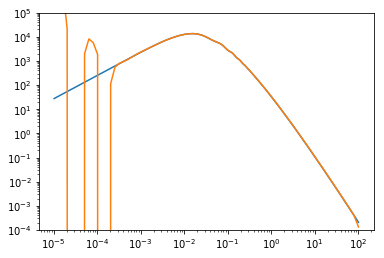

In [455]:
k, Pk = np.loadtxt('class_pk.dat', unpack = True)

start = time.time()

cn, pn = CoefPow(k, Pk)

stop = time.time()
print (start-stop)

PFFT = np.empty_like(k)
for i, _ in enumerate(PFFT):
    PFFT[i] = np.real( np.sum(cn * k[i]**pn) )

plt.loglog(k, Pk)
plt.loglog(k, PFFT)
plt.ylim(1e-4,1e5)

X0 IR-filter by FFTLog

(32,) (17,)


(0.0001, 1000000000000.0)

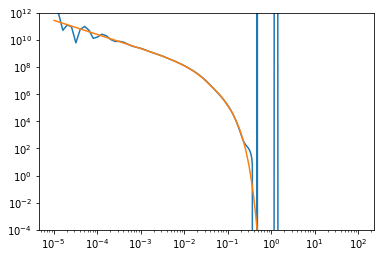

In [456]:
k, Pk = np.loadtxt('class_pk.dat', unpack = True)

LambdaIR = 0.12
cn, pn = CoefPow(k, np.exp(-k**2/LambdaIR**2)*Pk/k**2, bias = -2.6, Nmax = 32)

Pdk2 = np.empty_like(k)
for i, _ in enumerate(X0):
    Pdk2[i] = np.real( np.sum(cn * k[i]**pn) )

plt.loglog(k, Pdk2)
plt.loglog(k, np.exp(-k**2/LambdaIR**2) * Pk / k**2)
plt.ylim(1e-4,1e12)

Test Spherical Bessel Transform to get Cf11 and X0 and X2

In [457]:
def Mj(l, pn):
    return 1./(2.*np.pi**1.5) * 2.**(1.+pn) * gamma(0.5* (3.+l+pn) ) / gamma(0.5* (l-pn) )


(256,) (129,)
(32,) (17,)


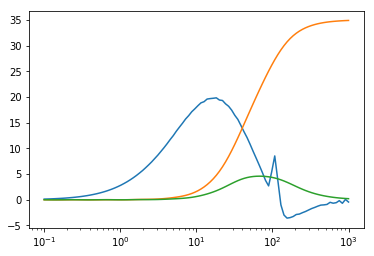

In [458]:
q = np.geomspace(0.1, 1000., 100)

cn, pn = CoefPow(k, Pk)
Mj0 = Mj(0, pn)

Cf = np.empty_like(q)
for i, qi in enumerate(q): Cf[i] = np.real( np.einsum('n,n,n->', Mj0, cn, qi**(-pn-3.) ) )

c0n, p0n = CoefPow(k, np.exp(-k**2/LambdaIR**2)*Pk/k**2, bias = -2.6, Nmax = 32)
MX0j0 = Mj(0, p0n)

X0 = np.empty_like(q)
for i, qi in enumerate(q): X0[i] = np.real( np.einsum('n,n,n->', MX0j0, c0n, qi**(-p0n-3.) ) )

X0 = X0[0]-X0 

MX0j2 = Mj(2, p0n)

X2 = np.empty_like(q)
for i, qi in enumerate(q): X2[i] = np.real( np.einsum('n,n,n->', MX0j2, c0n, qi**(-p0n-3.) ) )

plt.semilogx(q, q**2*Cf)
plt.semilogx(q, X0)
plt.semilogx(q, X2)

# FFTLog class

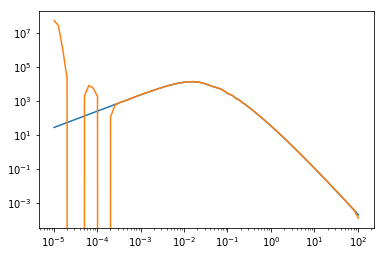

In [459]:
class CoefPow(object):
    def __init__(self, *args, **kwargs):
        if args is not None: self.F = interp1d(args[0], args[1])
        else: self.F = None
        self.bias = kwargs['bias']
        self.Nmax = kwargs['Nmax']
        self.xmin = kwargs['xmin']
        self.xmax = kwargs['xmax']
        self.dx = np.log(self.xmax/self.xmin) / (self.Nmax-1.)
        self.x = np.empty(self.Nmax)
        self.Fx = np.zeros(self.Nmax)
        self.setx()
        if self.F is not None: self.setFx()
        self.Pow = np.empty(self.Nmax+1, dtype = complex)
        self.setPow()
        self.tmp = np.empty(int(self.Nmax/2+1), dtype = complex)
        self.Coef = np.empty(self.Nmax+1, dtype = complex)
        if self.Fx.any(): self.setCoef()
    
    def setx(self):
        for i in range(self.Nmax): 
            self.x[i] = self.xmin * np.exp(i*self.dx)
            
    def setFx(self):
        for i in range(self.Nmax):
            self.Fx[i] = self.F(self.x[i]) * np.exp(-self.bias*i*self.dx)
        
    def setPow(self):
        for i in range(self.Nmax+1): 
            self.Pow[i] = self.bias + 1j * 2.*np.pi / (self.Nmax*self.dx) * (i - self.Nmax/2.)
    
    def setCoef(self):
        self.tmp = rfft(self.Fx)
        for i in range(self.Nmax+1):
            if (i < self.Nmax/2): self.Coef[i] = np.conj(self.tmp[int(self.Nmax/2-i)]) * self.xmin**(-self.Pow[i]) / float(self.Nmax)
            else: self.Coef[i] = self.tmp[int(i-self.Nmax/2)] * self.xmin**(-self.Pow[i]) / float(self.Nmax)
        
        self.Coef[0] /= 2.
        self.Coef[self.Nmax] /= 2.
    
    def sumCoefPow(self, k):
        PFFT = np.empty_like(k)
        for i, _ in enumerate(k):
            PFFT[i] = np.real( np.sum(self.Coef * k[i]**self.Pow) )
        return PFFT

P11 = CoefPow(k, Pk, bias = -1.6, Nmax = NFFT, xmin = kminFFT, xmax = kmaxFFT)
P11FFT = P11.sumCoefPow(k)
plt.loglog(k, Pk)
plt.loglog(k, P11FFT)

# Spherical Bessel Transform class

-0.00413203239440918


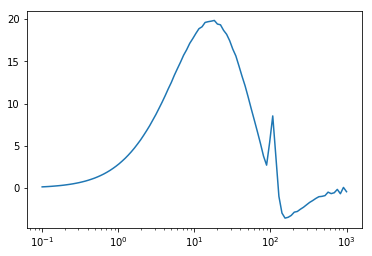

In [460]:
class sBTslow(object):
    def __init__(self, l, CoefPow):
        self.l = l
        self.Coef = CoefPow.Coef
        self.Pow = CoefPow.Pow
        self.M = np.empty_like(self.Pow)
        self.setM()
    
    def setM(self):
        if self.l is 0: self.M = -1./(2.*np.pi**2) * gamma(2.+self.Pow) * np.sin(0.5*self.Pow*np.pi)
        # equivalent for l = 0 but slightly slower
        else: self.M = 1./(2.*np.pi**1.5) * 2.**(1.+self.Pow) * gamma(0.5* (3.+self.l+self.Pow) ) / gamma(0.5* (self.l-self.Pow) )
    
    def dosBT(self, x):
        return np.real( np.einsum('n,n,n->', self.M, self.Coef, x**(-self.Pow-3.) ) )

q = np.geomspace(0.1, 1000., 100)
sBT0 = sBTslow(0, P11)
start = time.time()
Cf = np.empty_like(q)
for i, qi in enumerate(q): Cf[i] = sBT0.dosBT(qi)
stop = time.time()
print (start-stop)
plt.semilogx(q, q**2*Cf)

-0.00015807151794433594


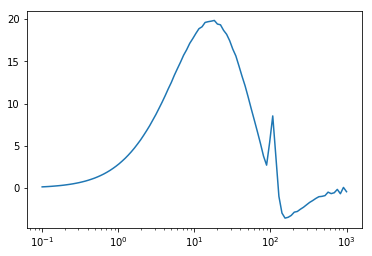

In [461]:
class sBTfast(object):
    def __init__(self, l, Pow, x):
        self.MxPow = np.einsum('n,nx->nx', self.M(l, Pow), np.exp(np.einsum('n,x->nx', -Pow-3., np.log(x))) )
        
    def M(self, l, Pow):
        if l is 0: return -1./(2.*np.pi**2) * gamma(2.+Pow) * np.sin(0.5*Pow*np.pi)
        # equivalent for l = 0 but slightly slower
        else: return 1./(2.*np.pi**1.5) * 2.**(1.+Pow) * gamma(0.5* (3.+l+Pow) ) / gamma(0.5* (l-Pow) )
        
    def dosBT(self, Coef):
        return np.real( np.einsum('n,nx->x', Coef, self.MxPow ) )

q = np.geomspace(0.1, 1000., 100)
sBT0 = sBTfast(0, P11.Pow, q)
start = time.time()
Cf = sBT0.dosBT(P11.Coef)
stop = time.time()
print (start-stop)
plt.semilogx(q, q**2*Cf)

In [462]:
class sBTfastopti(object):
    def __init__(self, l, Pow, x, Coef = None):
        self.MxPow = np.einsum('n,nx->nx', self.M(l, Pow), np.exp(np.einsum('n,x->nx', -Pow-3., np.log(x))) )
        if Coef is not None: self.optipath = np.einsum_path('n,nx->x', Coef, self.MxPow, optimize='optimal')[0]
        else: self.optipath = None
        
    def M(self, l, Pow):
        if l is 0: return -1./(2.*np.pi**2) * gamma(2.+Pow) * np.sin(0.5*Pow*np.pi)
        # equivalent for l = 0 but slightly slower
        else: return 1./(2.*np.pi**1.5) * 2.**(1.+Pow) * gamma(0.5* (3.+l+Pow) ) / gamma(0.5* (l-Pow) )
        
    def dosBT(self, Coef):
        return np.real( np.einsum('n,nx->x', Coef, self.MxPow, optimize=self.optipath ) )

q = np.geomspace(0.1, 1000., 100)
sBT0 = sBTfastopti(0, P11.Pow, q, P11.Coef)
start = time.time()
Cf = sBT0.dosBT(P11.Coef)
stop = time.time()
print (start-stop)

-0.0005366802215576172


# DM 1-loop

In [572]:
def M22(i, Pow):
    M = np.empty(shape=(Pow.shape[0], Pow.shape[0]), dtype='complex')
    for i, n1 in enumerate(-0.5*Pow):
        for j, n2 in enumerate(-0.5*Pow):
            M[i,j] = (((3. - 2. * n1 - 2. * n2) * (1. - 2. * n1 - 2. * n2) * (98. * n1 * n2 * (n1 + n2)**2 - 91. * (n1 + n2)**2 + 36. * n1 * n2 - 14. * n1 * n2 * (n1 + n2) + 3. * (n1 + n2) + 58.))/(196. * n1 * n2 * (1. + n1) * (1. - 2. * n1) * (1. + n2) * (1. - 2. * n2))) * (gamma(1.5 - n1) * gamma(1.5 - n2) * gamma(-1.5 + n1 + n2))/(8. * np.pi**1.5 * gamma(n1) * gamma(3. - n1 - n2) * gamma(n2))
    return M

def M13(i, Pow):
    n1 = -0.5*Pow
    return (1. + 9. * n1)/4. * np.tan(n1 *np.pi)/(28 *np.pi * (n1 + 1.) * n1 * (n1 - 1.) * (n1 - 2.) * (n1 - 3.))

In [571]:
class P13(object):
    def __init__(self, i, Pow, x):
        self.MxPow = np.einsum('x,n,nx->nx', x**3, M13(i, Pow), np.exp(np.einsum('n,x->nx', Pow, np.log(x))) )
    
    def makeloop(self, Coef, P11):
        return np.real( np.einsum('n,x,nx->x', Coef, P11, self.MxPow ) )

class P22(object):
    def __init__(self, i, Pow, x):
        xPow = np.exp(np.einsum('n,x->nx', Pow, np.log(x)))
        self.MxPow = np.einsum('x,nm,nx,mx->nmx', x**3, M22(i, Pow), xPow, xPow)
    
    def makeloop(self, Coef):
        return np.real( np.einsum('n,m,nmx->x', Coef, Coef, self.MxPow ) )

0.009020090103149414


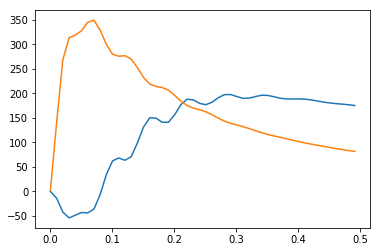

In [573]:
kp = np.arange(0.001, 0.5, 0.01)

P22DM = P22(0, P11.Pow, kp)
P13DM = P13(0, P11.Pow, kp)

start = time.time()
P22FFT = P22DM.makeloop(P11.Coef)
P13FFT = P13DM.makeloop(P11.Coef, P11.F(kp))
stop = time.time()
print(stop-start)

plt.plot(kp, P22FFT+P13FFT)
plt.plot(kp, kp*P11.F(kp))

# Bias 1-loop

In [550]:
M13b = {
    '0': lambda n1: 1.125,
    '1': lambda n1: -(1/(1 + n1)),
    '2': lambda n1: 2.25,
    '3': lambda n1: (3*(-1 + 3*n1))/(4.*(1 + n1)),
    '4': lambda n1: -(1/(1 + n1)),
    '5': lambda n1: -9/(4 + 4*n1),
    '6': lambda n1: (9 + 18*n1)/(4 + 4*n1),
    '7': lambda n1: (3*(-5 + 3*n1))/(8.*(1 + n1)),
    '8': lambda n1: -9/(4 + 4*n1),
    '9': lambda n1: (9*n1)/(4 + 4*n1)
}

def M13a(n1):
    return np.tan(n1*np.pi)/(14.*(-3 + n1)*(-2 + n1)*(-1 + n1)*n1*np.pi)

def M13(i, Pow):
    return M13a(-0.5*Pow) * M13b[str(i)](-0.5*Pow)


In [551]:
M22b = {
    '0': lambda n1, n2: (6 + n1**4*(4 - 24*n2) - 7*n2 + 8*n1**5*n2 - 13*n2**2 + 4*n2**3 + 4*n2**4 + n1**2*(-13 + 38*n2 + 12*n2**2 - 8*n2**3) + 2*n1**3*(2 - 5*n2 - 4*n2**2 + 8*n2**3) + n1*(-7 - 6*n2 + 38*n2**2 - 10*n2**3 - 24*n2**4 + 8*n2**5))/(4.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '1': lambda n1, n2: (-18 + n1**2*(1 - 11*n2) - 12*n2 + n2**2 + 10*n2**3 + 2*n1**3*(5 + 7*n2) + n1*(-12 - 38*n2 - 11*n2**2 + 14*n2**3))/(7.*n1*(1 + n1)*n2*(1 + n2)),
    '2': lambda n1, n2: (-3*n1 + 2*n1**2 + n2*(-3 + 2*n2))/(n1*n2),
    '3': lambda n1, n2: (-4*(-24 + n2 + 10*n2**2) + 2*n1*(-2 + 51*n2 + 21*n2**2) + n1**2*(-40 + 42*n2 + 98*n2**2))/(49.*n1*(1 + n1)*n2*(1 + n2)),
    '4': lambda n1, n2: (4*(3 - 2*n2 + n1*(-2 + 7*n2)))/(7.*n1*n2),
    '5': lambda n1, n2: 2,
    '6': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-2 + 3*n2 + 4*n1**4*n2 + 3*n2**2 - 2*n2**3 + n1**3*(-2 - 2*n2 + 4*n2**2) + n1**2*(3 - 10*n2 - 4*n2**2 + 4*n2**3) + n1*(3 + 2*n2 - 10*n2**2 - 2*n2**3 + 4*n2**4)))/(2.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '7': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(2 + 4*n2 + 5*n2**2 + n1**2*(5 + 7*n2) + n1*(4 + 10*n2 + 7*n2**2)))/(7.*n1*(1 + n1)*n2*(1 + n2)),
    '8': lambda n1, n2: ((n1 + n2)*(-3 + 2*n1 + 2*n2))/(n1*n2),
    '9': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(10 - 23*n2 + 28*n1**4*n2 + 5*n2**2 + 2*n2**3 + n1**3*(2 - 46*n2 + 28*n2**2) + n1**2*(5 - 38*n2 - 28*n2**2 + 28*n2**3) + n1*(-23 + 94*n2 - 38*n2**2 - 46*n2**3 + 28*n2**4)))/(14.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '10': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-58 + 4*n2 + 35*n2**2 + 7*n1**2*(5 + 7*n2) + n1*(4 + 14*n2 + 49*n2**2)))/(49.*n1*(1 + n1)*n2*(1 + n2)),
    '11': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-8 + 7*n1 + 7*n2))/(7.*n1*n2),
    '12': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(2 + 2*n1**3 - n2 - n2**2 + 2*n2**3 - n1**2*(1 + 2*n2) - n1*(1 + 2*n2 + 2*n2**2)))/(8.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '13': lambda n1, n2: ((1 + n1 + n2)*(2 + n1 + n2)*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    '14': lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(-6 - n1 + 2*n1**2 - n2 + 2*n2**2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    '15': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(38 + 41*n2 + 112*n1**3*n2 - 66*n2**2 + 2*n1**2*(-33 - 18*n2 + 56*n2**2) + n1*(41 - 232*n2 - 36*n2**2 + 112*n2**3)))/(56.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '16': lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(9 + 3*n1 + 3*n2 + 7*n1*n2))/(14.*n1*(1 + n1)*n2*(1 + n2)),
    '17': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(5 + 5*n1 + 5*n2 + 7*n1*n2))/(14.*n1*(1 + n1)*n2*(1 + n2)),
    '18': lambda n1, n2: (3 - 2*n1 - 2*n2)/(2.*n1*n2),
    '19': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(2.*n1*n2),
    '20': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(50 - 9*n2 + 98*n1**3*n2 - 35*n2**2 + 7*n1**2*(-5 - 18*n2 + 28*n2**2) + n1*(-9 - 66*n2 - 126*n2**2 + 98*n2**3)))/(196.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '21': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(2 + n1 + 4*n1**3 + n2 - 8*n1*n2 - 8*n1**2*n2 - 8*n1*n2**2 + 4*n2**3))/(8.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '22': lambda n1, n2: ((2 + n1 + n2)*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    '23': lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(-2 + 7*n1 + 7*n2))/(56.*n1*(1 + n1)*n2*(1 + n2)),
    '24': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(26 + 9*n2 + 56*n1**3*n2 - 38*n2**2 + 2*n1**2*(-19 - 18*n2 + 56*n2**2) + n1*(9 - 84*n2 - 36*n2**2 + 56*n2**3)))/(56.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '25': lambda n1, n2: (3*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(32.*n1*(1 + n1)*n2*(1 + n2)),
    '26': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2)*(1 + 2*n1**2 - 8*n1*n2 + 2*n2**2))/(16.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    '27': lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2)*(3 + 2*n1 + 2*n2))/(32.*n1*(1 + n1)*n2*(1 + n2)),
}

def M22a(n1, n2):
    return (gamma(1.5 - n1)*gamma(1.5 - n2)*gamma(-1.5 + n1 + n2))/(8.*Pi**1.5*gamma(n1)*gamma(3 - n1 - n2)*gamma(n2))

def M22(i, Pow):
    M = np.empty(shape=(Pow.shape[0], Pow.shape[0]), dtype='complex')
    for u, n1 in enumerate(-0.5*Pow):
        for v, n2 in enumerate(-0.5*Pow):
            M[u,v] = M22a(n1, n2) * M22b[str(i)](n1, n2)
    return M


Slow class

In [774]:
class P13b(object):
    def __init__(self, Pow, x, load=True, save=False, path='./'):
        self.N = 10 # number of 13-loops
        if load is True:
            try: self.MxPow = np.load(os.path.join(path, 'M13b.npy'))
            except: self.MxPow = self.makematrix(Pow, x, save=save, path=path)
        else:
            self.MxPow = self.makematrix(Pow, x, save=save, path=path)
    
    def makematrix(self, Pow, x, save=True, path='./'):
        M = np.empty(shape=(self.N, Pow.shape[0], x.shape[0]), dtype='complex')
        xPow = np.exp(np.einsum('n,x->nx', Pow, np.log(x)))
        for i in range(self.N): M[i] = np.einsum('x,n,nx->nx', x**3, M13(i, Pow), xPow )
        if save is True: np.save(os.path.join(path, 'M13b.npy'), M)
        return M
    
    def makeloop(self, i, Coef, P11k):
        return P11k * np.real( np.einsum('n,nx->x', Coef, self.MxPow[i]) )
        # return np.real( np.einsum('n,x,nx->x', Coef, P11k, self.MxPow[i] ) )

# This is fast to compute the loop, but slow to load the precomputed M22(n1,n2) * k^{i n1} * k^{i n2} * k^3
class P22b(object):
    def __init__(self, Pow, x, load=True, save=False, path='./'):
        self.N = 28 # number of 22-loops
        if load is True:
            try: 
                self.MxPow = np.load(os.path.join(path, 'M22b.npy'))
            except: self.MxPow = self.makematrix(Pow, x, save=save, path=path)
        else: 
            self.MxPow = self.makematrix(Pow, x, save=save, path=path)
        # for speeding-up the matrix multiplication:
        self.optipath = np.einsum_path('n,m,nmx->x', Pow, Pow, self.MxPow[0], optimize='optimal')[0]
    
    def makematrix(self, Pow, x, save=True, path='./'):
        M = np.empty(shape=(self.N, Pow.shape[0], Pow.shape[0], x.shape[0]), dtype='complex')
        xPow = np.exp(np.einsum('n,x->nx', Pow, np.log(x)))
        for i in range(self.N): M[i] = np.einsum('x,nm,nx,mx->nmx', x**3, M22(i, Pow), xPow, xPow)
        if save is True: np.save(os.path.join(path, 'M22b.npy'), M)
        return M
    
    def makeloop(self, i, Coef):
        return np.real( np.einsum('n,m,nmx->x', Coef, Coef, self.MxPow[i], optimize=self.optipath ) )

In [775]:
ps13b = P13b(P11.Pow, kp, load=True, save=False, path = './')
ps22b = P22b(P11.Pow, kp, load=True, save=False, path = './')

In [788]:
start = time.time()
for i in range(ps22b.N): loop22 = ps22b.makeloop(i, P11.Coef)
# for i in range(ps13b.N): loop13 = ps13b.makeloop(i, P11.Coef, P11.F(kp))
stop = time.time()
print(stop-start)

0.20684170722961426


Fast class

In [778]:
# This is faster that P22b to load and also faster to compute the loops
class P22(object):
    def __init__(self, Pow, x, load=True, save=False, path='./'):
        self.N = 28 # number of 22-loops
        if load is True:
            try: 
                self.M = np.load(os.path.join(path, 'M22.npy'))
            except: self.M = self.makematrix(Pow, save=save, path=path)
        else: 
            self.M = self.makematrix(Pow, save=save, path=path)
        # for speeding-up the matrix multiplication:
        CoefxPow = np.einsum('n,nx->nx', Pow, np.exp(np.einsum('n,x->nx', Pow, np.log(x))) )
        self.optipath = np.einsum_path('nx,mx,nm->x', CoefxPow, CoefxPow, self.M[0], optimize='optimal')[0]
    
    def makematrix(self, Pow, save=True, path='./'):
        M = np.empty(shape=(self.N, Pow.shape[0], Pow.shape[0]), dtype='complex')
        for i in range(self.N): M[i] = M22(i, Pow)
        if save is True: np.save(os.path.join(path, 'M22.npy'), M)
        return M
    
    def makeloop(self, i, Coef, Pow, x):
        CoefxPow = np.einsum('n,nx->nx', Coef, np.exp(np.einsum('n,x->nx', Pow, np.log(x))) )
        return np.real( np.einsum('x,nx,mx,nm->x', x**3, CoefxPow, CoefxPow, self.M[i], optimize=self.optipath ) )

# P13b is marginally faster than P13. They are both fast (< ~ 0.01 s) so either can do
class P13(object):
    def __init__(self, Pow, x, load=True, save=False, path='./'):
        self.N = 10 # number of 13-loops
        if load is True:
            try: self.M = np.load(os.path.join(path, 'M13.npy'))
            except: self.M = self.makematrix(Pow, save=save, path=path)
        else:
            self.M = self.makematrix(Pow, save=save, path=path)
    
    def makematrix(self, Pow, save=True, path='./'):
        M = np.empty(shape=(self.N, Pow.shape[0]), dtype='complex')
        for i in range(self.N): M[i] = M13(i, Pow)
        if save is True: np.save(os.path.join(path, 'M13.npy'), M)
        return M
    
    def makeloop(self, i, Coef, Pow, k, P11k):
        CoefxPow = np.einsum('n,nx->nx', Coef, np.exp(np.einsum('n,x->nx', Pow, np.log(k))) )
        return k**3 * P11k * np.real( np.einsum('nx,n->x', CoefxPow, self.M[i]) )
        # return np.real( np.einsum('n,x,nx->x', Coef, P11k, self.MxPow[i] ) )

In [781]:
start = time.time()
ps22 = P22(P11.Pow, kp, load=True, save=False, path = './')
ps13 = P13(P11.Pow, kp, load=True, save=False, path = './')
stop = time.time()
print(stop-start)

0.05259299278259277


In [795]:
loop22 = np.empty(ps22.N)
loop13 = np.empty(ps13.N)

start = time.time()
for i in range(ps22.N): loop22 = ps22.makeloop(i, P11.Coef, P11.Pow, kp)
P11kp = P11.F(kp)
for i in range(ps13.N): loop13 = ps13.makeloop(i, P11.Coef, P11.Pow, kp, P11kp)
stop = time.time()
print(stop-start)

0.10525703430175781


# In Dev

In [790]:
fitCMASS = {'b1': 2.22, 'b2': 1.2 / np.sqrt(2.), 'b3': 0.1, 'b4': 1.2 / np.sqrt(2.),
        'b5': 0.4, 'b6': -7.7, 'b7': 0., 'b8': 0.0,
        'b9': 0., 'b10': -3.7, 'b11': 0,
        'e1': 0, 'e2': 0}

def get_biasloop(d_fit):
    return np.array([#0, 1., d_fit['b1'], d_fit['b1']**2, 
                      1., d_fit['b1'], d_fit['b2'], d_fit['b3'], d_fit['b4'],
                      d_fit['b1']**2, d_fit['b1'] * d_fit['b2'], d_fit['b1'] * d_fit['b3'], d_fit['b1'] * d_fit['b4'],
                      d_fit['b2']**2, d_fit['b2'] * d_fit['b4'], d_fit['b4']**2,
                      d_fit['b1'] * d_fit['b5'] / knl**2, d_fit['b1'] * d_fit['b6'] / km**2,
                      d_fit['b1'] * d_fit['b7'] / km**2, d_fit['b5'] / knl**2, d_fit['b6'] / km**2, d_fit['b7'] / km**2])

def get_PSbias(name, dfit):
    
    PS = np.einsum('c,mkc->mk', get_biasloop(dfit), ploop)
    PS[0] = PS[0] + dfit['b8'] / nd + dfit['b9'] / nd / km**2 * k**2
    PS[1] = PS[1] + dfit['b10'] / nd / km**2 * k**2
    return k, PS

In [ ]:
plt.plot()